In [18]:
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, CenteredNorm
import numpy as np
from copy import deepcopy
from pprint import pprint
from pyHalo.preset_models import preset_model_from_name

import mejiro
plt.style.use(os.path.join(mejiro.__path__[0], 'mejiro.mplstyle'))
from mejiro.analysis import stats
from mejiro.exposure import Exposure
from mejiro.instruments.roman import Roman
from mejiro.galaxy_galaxy import Sample1, Sample2, SampleGG
from mejiro.synthetic_image import SyntheticImage
from mejiro.utils import lenstronomy_util
from mejiro.engines.galsim_engine import GalSimEngine
from mejiro.engines.stpsf_engine import STPSFEngine

In [19]:
strong_lens = Sample1()

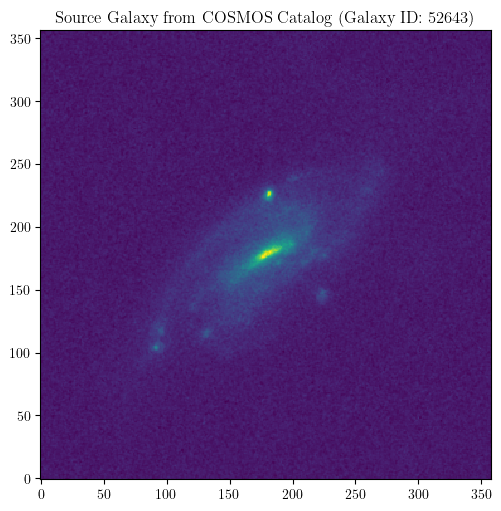

In [20]:
plt.imshow(strong_lens.kwargs_source[0]['image'])
plt.title(f'Source Galaxy from COSMOS Catalog (Galaxy ID: {strong_lens.physical_params["galaxy_id"]})')
plt.show()

In [21]:
kwargs_numerics = SyntheticImage.DEFAULT_KWARGS_NUMERICS
pprint(kwargs_numerics)

{'compute_indexes': None,
 'compute_mode': 'regular',
 'flux_evaluate_indexes': None,
 'point_source_supersampling_factor': 5,
 'supersampled_indexes': None,
 'supersampling_convolution': True,
 'supersampling_factor': 5,
 'supersampling_kernel_size': None}


Generating PSF with STPSF, which may be slow. Consider caching frequently-used PSFs.


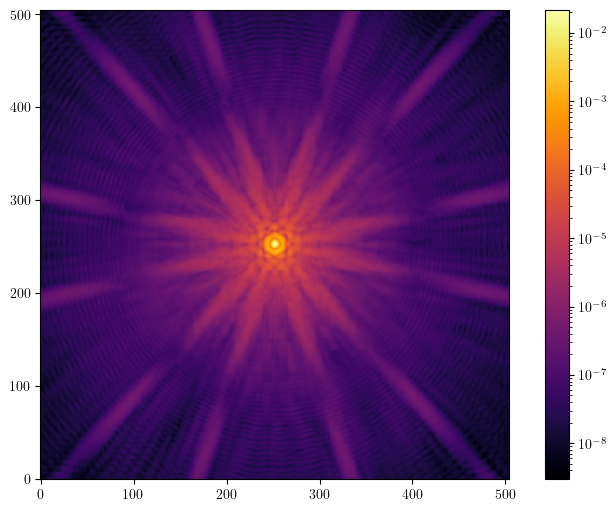

In [22]:
roman = Roman()
band = 'F129'

instrument_params = roman.default_params()
kernel = STPSFEngine.get_roman_psf(band=band,
                                   detector=instrument_params['detector'],
                                   detector_position=instrument_params['detector_position'],
                                   oversample=kwargs_numerics['supersampling_factor'],
                                   num_pix=101,
                                   verbose=True)
kwargs_psf = lenstronomy_util.get_pixel_psf_kwargs(kernel=kernel,
                                                   supersampling_factor=kwargs_numerics['supersampling_factor'])

plt.imshow(kernel, cmap='inferno', norm=LogNorm())
plt.colorbar()
plt.show()

Scene size: 5.17 arcsec, 47 pixels at pixel scale 0.11 arcsec/pix
Synthetic image calculation time: 0.119 s


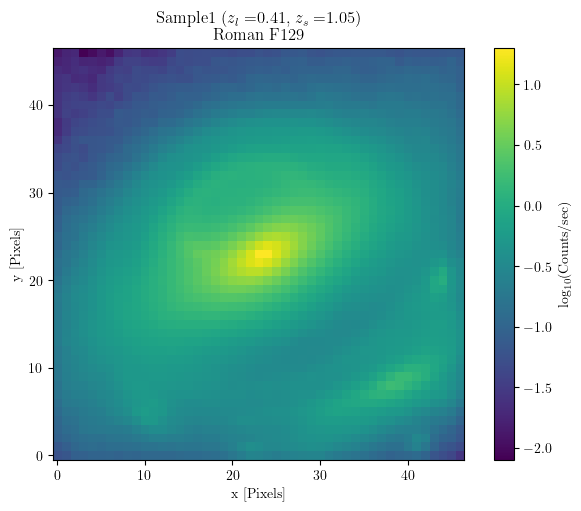

In [23]:
synthetic_image = SyntheticImage(strong_lens,
                                 instrument=roman,
                                 band=band,
                                 fov_arcsec=5,
                                 instrument_params=instrument_params,
                                 kwargs_numerics=kwargs_numerics,
                                 kwargs_psf=kwargs_psf,
                                 pieces=True,
                                 verbose=True)

synthetic_image.plot()

In [24]:
supersampling_factors = [1, 3, 5, 7, 9, 11, 13, 15]
kernels = []
images = []
calc_times = []

for supersampling_factor in supersampling_factors:
    kwargs_numerics = {
        'compute_mode': 'regular',
        'supersampling_factor': supersampling_factor,
    }
    
    kernel = STPSFEngine.get_roman_psf(band=band,
                                    detector=instrument_params['detector'],
                                    detector_position=instrument_params['detector_position'],
                                    oversample=kwargs_numerics['supersampling_factor'],
                                    num_pix=101,
                                    verbose=True)
    kernels.append(kernel)

    kwargs_psf = lenstronomy_util.get_pixel_psf_kwargs(kernel=kernel,
                                                    supersampling_factor=kwargs_numerics['supersampling_factor'])
    
    synthetic_image = SyntheticImage(deepcopy(strong_lens),
                                 instrument=roman,
                                 band=band,
                                 fov_arcsec=5,
                                 instrument_params=instrument_params,
                                 kwargs_numerics=kwargs_numerics,
                                 kwargs_psf=kwargs_psf,
                                 pieces=True,
                                 verbose=True)
    images.append(synthetic_image.image)
    calc_times.append(synthetic_image.calc_time)

Generating PSF with STPSF, which may be slow. Consider caching frequently-used PSFs.
Scene size: 5.17 arcsec, 47 pixels at pixel scale 0.11 arcsec/pix
Synthetic image calculation time: 0.027 s
Generating PSF with STPSF, which may be slow. Consider caching frequently-used PSFs.
Scene size: 5.17 arcsec, 47 pixels at pixel scale 0.11 arcsec/pix
Synthetic image calculation time: 0.05 s
Generating PSF with STPSF, which may be slow. Consider caching frequently-used PSFs.
Scene size: 5.17 arcsec, 47 pixels at pixel scale 0.11 arcsec/pix
Synthetic image calculation time: 0.093 s
Generating PSF with STPSF, which may be slow. Consider caching frequently-used PSFs.
Scene size: 5.17 arcsec, 47 pixels at pixel scale 0.11 arcsec/pix
Synthetic image calculation time: 0.135 s
Generating PSF with STPSF, which may be slow. Consider caching frequently-used PSFs.
Scene size: 5.17 arcsec, 47 pixels at pixel scale 0.11 arcsec/pix
Synthetic image calculation time: 0.176 s
Generating PSF with STPSF, which may

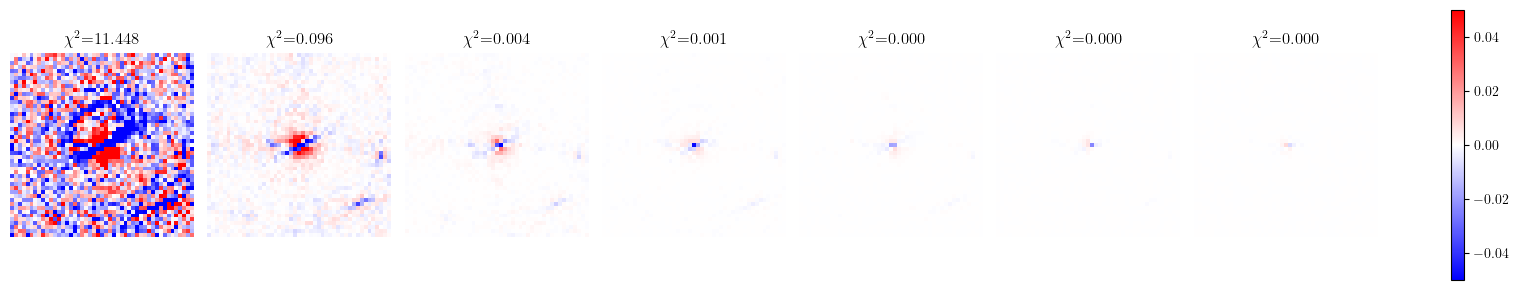

In [25]:
vmax = max(np.max(np.abs(images[-1] - img)) for img in images)
vmin = -vmax

vmin=-0.05
vmax=0.05

f, ax = plt.subplots(1, len(images) - 1, figsize=(15, 3))
for i, img in enumerate(images[:-1]):
    diff = images[-1] - img
    chi2 = stats.chi_square(img, images[-1])
    im = ax[i].imshow(diff, cmap='bwr', vmin=vmin, vmax=vmax)
    ax[i].set_title(r'$\chi^2$' + f'={chi2:.3f}')
    ax[i].axis('off')
plt.tight_layout()
f.colorbar(im, ax=ax, orientation='vertical', fraction=0.02)
plt.show()

In [26]:
images_with_substructure = []
calc_times_with_substructure = []

strong_lens_with_substructure = deepcopy(strong_lens)
CDM = preset_model_from_name('CDM')
realization = CDM(round(strong_lens_with_substructure.z_lens, 2), round(strong_lens_with_substructure.z_source, 2), cone_opening_angle_arcsec=5, log_m_host=np.log10(strong_lens_with_substructure.get_main_halo_mass()))
strong_lens_with_substructure.add_realization(realization)

for supersampling_factor, kernel in zip(supersampling_factors, kernels):
    kwargs_numerics = {
        'compute_mode': 'regular',
        'supersampling_factor': supersampling_factor,
    }

    kwargs_psf = lenstronomy_util.get_pixel_psf_kwargs(kernel=kernel,
                                                    supersampling_factor=kwargs_numerics['supersampling_factor'])
    
    synthetic_image = SyntheticImage(deepcopy(strong_lens_with_substructure),
                                 instrument=roman,
                                 band=band,
                                 fov_arcsec=5,
                                 instrument_params=instrument_params,
                                 kwargs_numerics=kwargs_numerics,
                                 kwargs_psf=kwargs_psf,
                                 pieces=True,
                                 verbose=True)
    images_with_substructure.append(synthetic_image.image)
    calc_times_with_substructure.append(synthetic_image.calc_time)

Scene size: 5.17 arcsec, 47 pixels at pixel scale 0.11 arcsec/pix
Synthetic image calculation time: 1.295 s
Scene size: 5.17 arcsec, 47 pixels at pixel scale 0.11 arcsec/pix
Synthetic image calculation time: 1.406 s
Scene size: 5.17 arcsec, 47 pixels at pixel scale 0.11 arcsec/pix
Synthetic image calculation time: 1.771 s
Scene size: 5.17 arcsec, 47 pixels at pixel scale 0.11 arcsec/pix
Synthetic image calculation time: 2.008 s
Scene size: 5.17 arcsec, 47 pixels at pixel scale 0.11 arcsec/pix
Synthetic image calculation time: 2.926 s
Scene size: 5.17 arcsec, 47 pixels at pixel scale 0.11 arcsec/pix
Synthetic image calculation time: 4.192 s
Scene size: 5.17 arcsec, 47 pixels at pixel scale 0.11 arcsec/pix
Synthetic image calculation time: 5.755 s
Scene size: 5.17 arcsec, 47 pixels at pixel scale 0.11 arcsec/pix
Synthetic image calculation time: 7.591 s


Scene size: 5.17 arcsec, 47 pixels at pixel scale 0.11 arcsec/pix
Synthetic image calculation time: 7.587 s


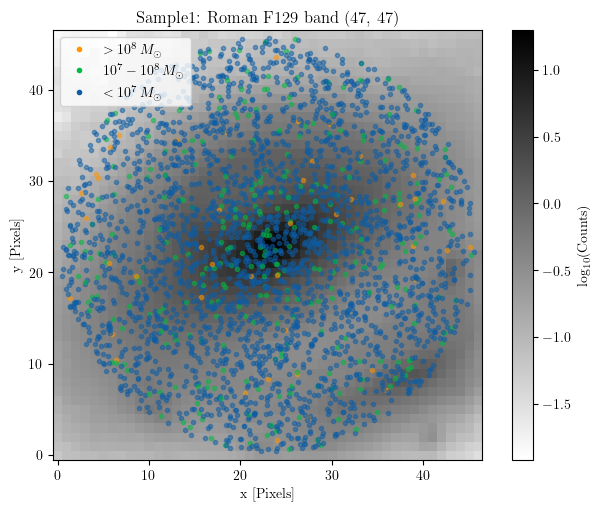

In [27]:
synthetic_image_with_substructure = SyntheticImage(strong_lens_with_substructure,
                                 instrument=roman,
                                 band=band,
                                 fov_arcsec=5,
                                 instrument_params=instrument_params,
                                 kwargs_numerics=kwargs_numerics,
                                 kwargs_psf=kwargs_psf,
                                 pieces=True,
                                 verbose=True)

synthetic_image_with_substructure.overplot_subhalos()

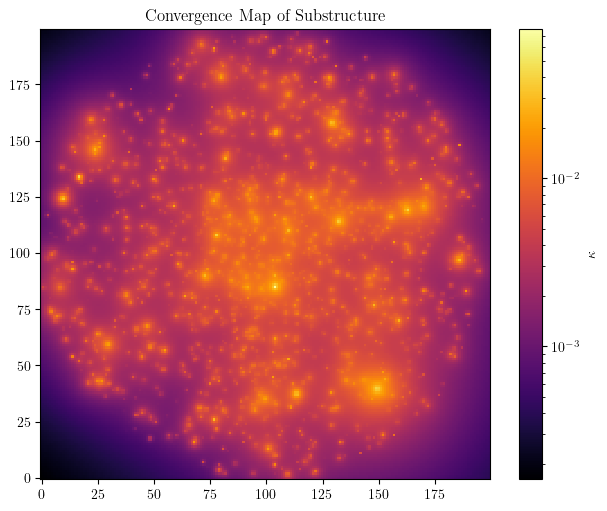

In [28]:
kappa = strong_lens_with_substructure.get_realization_kappa(fov_arcsec=5, num_pix=200)

plt.imshow(kappa, cmap='inferno', norm=LogNorm())
plt.colorbar(label=r'$\kappa$')
plt.title('Convergence Map of Substructure')
plt.show()

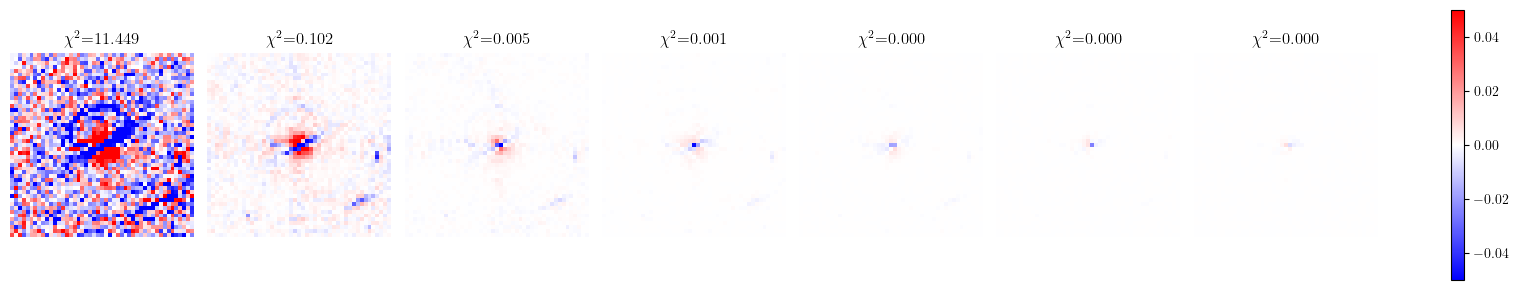

In [29]:
vmax = max(np.max(np.abs(images_with_substructure[-1] - img)) for img in images_with_substructure)
vmin = -vmax

vmin=-0.05
vmax=0.05

f, ax = plt.subplots(1, len(images_with_substructure) - 1, figsize=(15, 3))
for i, img in enumerate(images_with_substructure[:-1]):
    diff = images_with_substructure[-1] - img
    chi2 = stats.chi_square(img, images_with_substructure[-1])
    im = ax[i].imshow(diff, cmap='bwr', vmin=vmin, vmax=vmax)
    ax[i].set_title(r'$\chi^2$' + f'={chi2:.3f}')
    ax[i].axis('off')
plt.tight_layout()
f.colorbar(im, ax=ax, orientation='vertical', fraction=0.02)
plt.show()

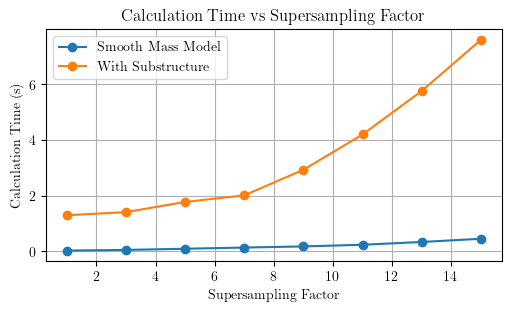

In [30]:
plt.figure(figsize=(5, 3))
plt.plot(supersampling_factors, calc_times, marker='o', label='Smooth Mass Model')
plt.plot(supersampling_factors, calc_times_with_substructure, marker='o', label='With Substructure')
plt.xlabel('Supersampling Factor')
plt.ylabel('Calculation Time (s)')
plt.title('Calculation Time vs Supersampling Factor')
plt.grid(True)
plt.legend()
plt.show()

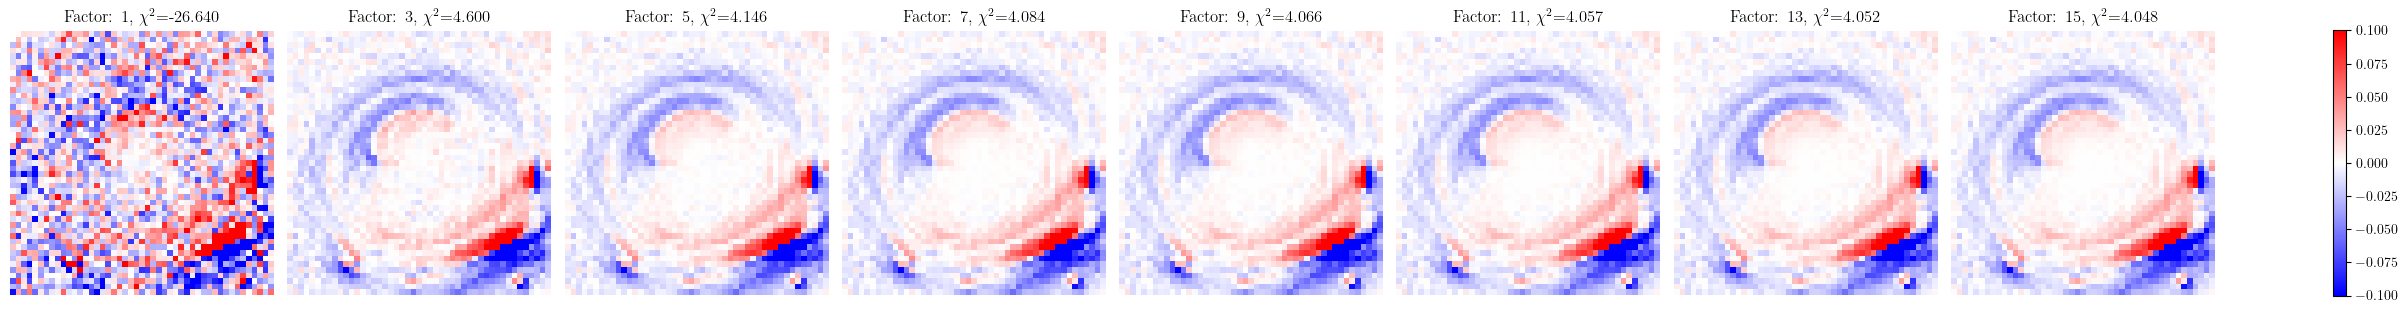

In [31]:
f, ax = plt.subplots(1, len(images), figsize=(len(images) * 3, 3))

vmin = -0.1
vmax = 0.1

for i, (factor, img, img_with) in enumerate(zip(supersampling_factors, images, images_with_substructure)):
    diff = img_with - img
    chi2 = stats.chi_square(img, img_with)
    im = ax[i].imshow(diff, cmap='bwr', vmin=vmin, vmax=vmax)
    ax[i].set_title(f'Factor: {factor}, ' + r'$\chi^2$' + f'={chi2:.3f}')
    ax[i].axis('off')
plt.tight_layout()
f.colorbar(im, ax=ax, orientation='vertical', fraction=0.02)
plt.show()